TSORMPATZOGLOU IOANNIS

NTUA, HEP

PyHEADTAIL Simulation Framework

Single-bunch tracking with Simple Harmonic Motion (SHM) using PyHEADTAIL Particles object.
Goal:
1. Model a particle bunch as macroparticles with initial distributions.
2. Apply a restoring force (F = -k*x) that mimics simple harmonic motion.
3. Track evolution of each particle in transverse phase space (x, x').
4. Study centroid motion and visualize phase-space dynamics.


# Imports and setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from PyHEADTAIL.particles import Particles
from scipy.special import wofz # Faddeeva function (not used yet, for later beam-beam effects)

PyHEADTAIL v1.16.5


# Physics helper functions

In [2]:
def apply_kick_SHM(x, xp):
    """
    Apply the restoring force of a harmonic oscillator:
    F = -k*x → Δxp = -k*x.


     Args:
     x : transverse positions of particles (array)
     xp : transverse slopes (momenta) of particles (array)


    Returns:
    Updated transverse slopes after the kick.
    """
    xp -= k * x
    return xp

In [3]:
def update_position(x, xp, dz=1):
   """
   Drift update for particle positions:
   dx/dz = xp → x_new = x_old + xp*dz.


   Args:
   x : transverse positions (array)
   xp : transverse slopes (array)
   dz : step length in z (default=1)


   Returns:
   Updated transverse positions.
   """
   x += xp * dz
   return x

# Initialization of the beam

In [4]:
N   = 1000 # number of macroparticles in the bunch
x0  = 1e-6 # initial sigma of x distribution [m]
y0  = 1e-6 # initial sigma of y distribution [m]
xp0 = 1e-6 # initial sigma of x' distribution [rad]
yp0 = 1e-6 # initial sigma of y' distribution [rad]
k   = 3e-2 # restoring force constant for SHM

Generate Gaussian-distributed initial conditions (centroid centered around 0):

In [5]:
dist_x  = np.random.normal(loc=0.0, scale=x0,  size=N)
dist_xp = np.random.normal(loc=0.0, scale=xp0, size=N)
dist_y  = np.random.normal(loc=0.0, scale=y0,  size=N)
dist_yp = np.random.normal(loc=0.0, scale=yp0, size=N)

Create Particles object (beam):

In [6]:
particles = Particles(
macroparticlenumber=N, # number of macroparticles
particlenumber_per_mp=10000, # real particles per macroparticle
charge=1.6202e-19, # proton charge [C]
mass=1.6726219e-27, # proton mass [kg]
circumference=1.0, # toy ring circumference = 1 m
gamma=1.0, # non-relativistic
coords_n_momenta_dict={ # initial conditions
'x' : dist_x,
'xp': dist_xp,
'y' : dist_y,
'yp': dist_yp
}
)

Extract coordinates dictionary for easy access:

In [7]:
coords = particles.get_coords_n_momenta_dict()

# Tracking loop

In [8]:
steps             = 200 # number of turns 
centroid          = []  # centroid trajectory (x)
phase_space_steps = []  # phase-space snapshots (x, x')

In [9]:
for step in range(steps):
    # Apply harmonic oscillator kick:
    xp_step = apply_kick_SHM(coords['x'], coords['xp'])


    # Update transverse positions with drift:
    x_step = update_position(coords['x'], coords['xp'])


    # Save centroid position (mean x over all particles):
    centroid.append(np.mean(x_step))


    # Save full phase-space snapshot for animation:
    phase_space_steps.append((x_step.copy(), xp_step.copy()))

# Visualization setup

MovieWriter Pillow unavailable; using Pillow instead.


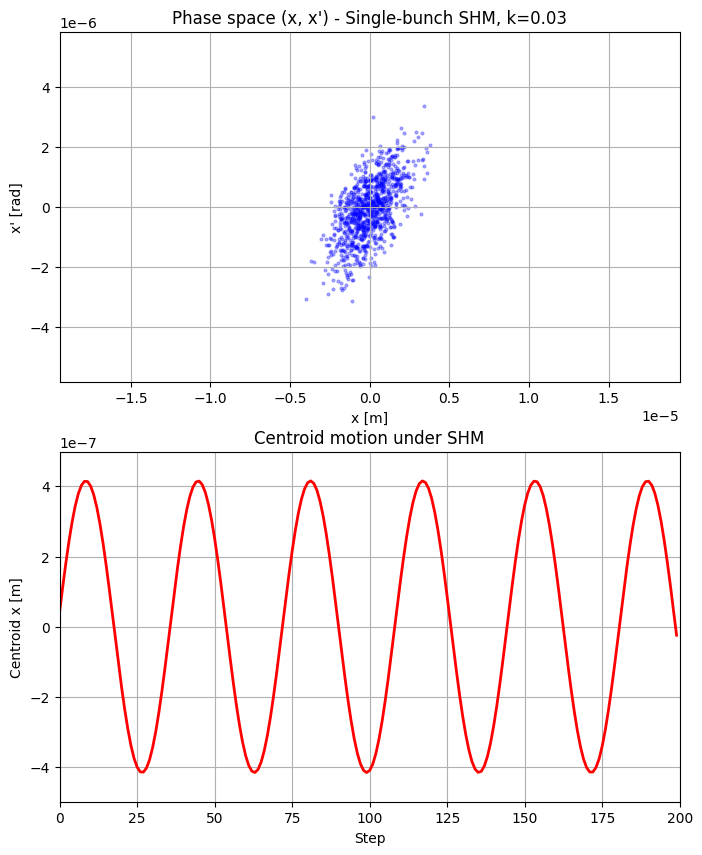

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))


# --- Phase space subplot (x, x') ---
ax1.set_xlim(np.min(phase_space_steps), np.max(phase_space_steps))  
ax1.set_ylim(10 * k * np.min(phase_space_steps), 10 * k * np.max(phase_space_steps))
ax1.set_xlabel("x [m]")
ax1.set_ylabel("x' [rad]")
ax1.set_title(f"Phase space (x, x') - Single-bunch SHM, k={k}")
ax1.grid(True)
scatter = ax1.scatter([], [], s=4, c='blue', alpha=0.3)


# --- Centroid motion subplot ---
ax2.set_xlim(0, len(centroid))
ax2.set_ylim(1.2 * min(centroid), 1.2 * max(centroid))
ax2.set_xlabel("Step")
ax2.set_ylabel("Centroid x [m]")
ax2.set_title("Centroid motion under SHM")
ax2.grid(True)
line, = ax2.plot([], [], lw=2, c='red')

def animate(i):
    # Update phase-space scatter plot
    data = np.vstack(phase_space_steps[i]).T
    scatter.set_offsets(data)


    # Update centroid trajectory
    line.set_data(range(i+1), centroid[:i+1])
    return scatter, line

# Run animation
from IPython.display import HTML

anim = animation.FuncAnimation(fig, animate, frames=len(centroid), interval=50, blit=True)
HTML(anim.to_html5_video())


# (Optional) save as gif
anim.save(filename="SHM.gif", writer='Pillow')